Intitalize All functions

In [11]:
from PIL import Image
import numpy as np
import torch
import torch
import os

model_root_path = 'model/tidl'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

if DEVICE == 'cpu':
    torch.set_num_threads(os.cpu_count())
    
def preprocess_images(image_paths, input_size, mean, std):
    images = []
    for path in image_paths:
        # 讀取並確保RGB
        img = Image.open(path).convert('RGB')
        new_img_width = input_size[1]
        new_img_height = float(new_img_width) / img.size[0] * img.size[1]
        
        # Resize
        img_resized = img.resize((int(new_img_width), int(new_img_height)), Image.LANCZOS)
        crop_x = (img_resized.size[0] - input_size[1]) / 2
        crop_y = (img_resized.size[1] - input_size[0]) / 2

        crop_img = img_resized.crop((crop_x, crop_y, crop_x+input_size[1], crop_y+input_size[0]))
        assert crop_img.size[0] == input_size[1] and crop_img.size[1] == input_size[0]

        # 轉為Tensor(H,W,C)
        img_tensor = torch.from_numpy(np.array(crop_img)).float().to(DEVICE)  # shape: (H, W, C)
        
        # 减均值，除標準差 (mean,std為C维度大小的tensor)
        # 須先將Img tensor從 HWC -> CHW
        img_tensor = img_tensor.permute(2,0,1)  # (C,H,W)
        
        # Broadcasting: (C,H,W) - (C,1,1) / (C,1,1)
        # 將mean, std reshape成 (C,1,1)
        mean = mean.view(-1,1,1)
        std = std.view(-1,1,1)
        
        img_normalized = (img_tensor - mean) / std
        
        images.append(img_normalized)

    # 將所有影像打包成 (N, C, H, W)
    batch_images = torch.stack(images, dim=0)
    return batch_images
    
batch_size = 6
num_cameras = 6
channels = 3
height = 256
width = 704


output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
accu_time = 0

def next_image_paths(imgid):
    return [
        f'data/samples/front/front_{imgid}.jpg',
        f'data/samples/front_right/front_right_{imgid}.jpg',
        f'data/samples/front_left/front_left_{imgid}.jpg',
        f'data/samples/back/back_{imgid}.jpg',
        f'data/samples/back_left/back_left_{imgid}.jpg',
        f'data/samples/back_right/back_right_{imgid}.jpg',
    ]

def cross(p1, p2, p0):
    # 计算向量 (p1 - p0) 和 (p2 - p0) 的叉积
    return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])
    
def check_box2d(box, p):
    # 检查点 p 是否在旋转矩形 box 内部
    MARGIN = 1e-5
    center_x = (box[0] + box[2]) / 2
    center_y = (box[1] + box[3]) / 2
    angle_cos = np.cos(-box[4])
    angle_sin = np.sin(-box[4])
    rot_x = (p[0] - center_x) * angle_cos + (p[1] - center_y) * angle_sin + center_x
    rot_y = -(p[0] - center_x) * angle_sin + (p[1] - center_y) * angle_cos + center_y
    return (rot_x > (box[0] - MARGIN) and rot_x < (box[2] + MARGIN) and
            rot_y > (box[1] - MARGIN) and rot_y < (box[3] + MARGIN))

def intersection(p1, p0, q1, q0):
    # 计算两条线段 (p0, p1) 和 (q0, q1) 的交点
    # 返回 (交点存在标志, 交点坐标)
    ThresHold = 1e-8
    if not (min(p0[0], p1[0]) <= max(q0[0], q1[0]) and
            min(q0[0], q1[0]) <= max(p0[0], p1[0]) and
            min(p0[1], p1[1]) <= max(q0[1], q1[1]) and
            min(q0[1], q1[1]) <= max(p0[1], p1[1])):
        return False, None

    s1 = cross(q0, p1, p0)
    s2 = cross(p1, q1, p0)
    s3 = cross(p0, q1, q0)
    s4 = cross(q1, p1, q0)

    if not (s1 * s2 > 0 and s3 * s4 > 0):
        return False, None

    s5 = cross(q1, p1, p0)
    if abs(s5 - s1) > ThresHold:
        ans_x = (s5 * q0[0] - s1 * q1[0]) / (s5 - s1)
        ans_y = (s5 * q0[1] - s1 * q1[1]) / (s5 - s1)
    else:
        a0 = p0[1] - p1[1]
        b0 = p1[0] - p0[0]
        c0 = p0[0] * p1[1] - p1[0] * p0[1]
        a1 = q0[1] - q1[1]
        b1 = q1[0] - q0[0]
        c1 = q0[0] * q1[1] - q1[0] * q0[1]
        D = a0 * b1 - a1 * b0
        ans_x = (b0 * c1 - b1 * c0) / D
        ans_y = (a1 * c0 - a0 * c1) / D

    return True, (ans_x, ans_y)

def rotate_around_center(center, angle_cos, angle_sin, p):
    # 绕中心点旋转点 p
    new_x = (p[0] - center[0]) * angle_cos + (p[1] - center[1]) * angle_sin + center[0]
    new_y = -(p[0] - center[0]) * angle_sin + (p[1] - center[1]) * angle_cos + center[1]
    return [new_x, new_y]

def box_overlap(box_a, box_b):
    # 计算两个旋转矩形的重叠面积
    ThresHold = 1e-8
    a_angle = box_a[4]
    b_angle = box_b[4]
    a_x1, a_y1, a_x2, a_y2 = box_a[0], box_a[1], box_a[2], box_a[3]
    b_x1, b_y1, b_x2, b_y2 = box_b[0], box_b[1], box_b[2], box_b[3]
    box_a_corners = []
    box_b_corners = []
    cross_points = []
    poly_center = [0, 0]
    cnt = 0

    center_a = [(a_x1 + a_x2) / 2, (a_y1 + a_y2) / 2]
    center_b = [(b_x1 + b_x2) / 2, (b_y1 + b_y2) / 2]

    box_a_corners = [
        [a_x1, a_y1],
        [a_x2, a_y1],
        [a_x2, a_y2],
        [a_x1, a_y2],
    ]

    box_b_corners = [
        [b_x1, b_y1],
        [b_x2, b_y1],
        [b_x2, b_y2],
        [b_x1, b_y2],
    ]

    a_angle_cos = np.cos(a_angle)
    a_angle_sin = np.sin(a_angle)
    b_angle_cos = np.cos(b_angle)
    b_angle_sin = np.sin(b_angle)

    for k in range(4):
        box_a_corners[k] = rotate_around_center(center_a, a_angle_cos, a_angle_sin, box_a_corners[k])
        box_b_corners[k] = rotate_around_center(center_b, b_angle_cos, b_angle_sin, box_b_corners[k])

    box_a_corners.append(box_a_corners[0])  # 闭合多边形
    box_b_corners.append(box_b_corners[0])

    # 寻找交点
    for i in range(4):
        for j in range(4):
            flag, ans = intersection(box_a_corners[i + 1], box_a_corners[i], box_b_corners[j + 1], box_b_corners[j])
            if flag:
                poly_center[0] += ans[0]
                poly_center[1] += ans[1]
                cross_points.append(ans)
                cnt += 1

    # 检查是否有顶点在对方的矩形内部
    for k in range(4):
        if check_box2d(box_a, box_b_corners[k]):
            poly_center[0] += box_b_corners[k][0]
            poly_center[1] += box_b_corners[k][1]
            cross_points.append(box_b_corners[k])
            cnt += 1
        if check_box2d(box_b, box_a_corners[k]):
            poly_center[0] += box_a_corners[k][0]
            poly_center[1] += box_a_corners[k][1]
            cross_points.append(box_a_corners[k])
            cnt += 1

    if cnt == 0:
        return 0.0

    poly_center[0] /= cnt
    poly_center[1] /= cnt

    # 根据极角排序
    def angle_cmp(p):
        return np.arctan2(p[1] - poly_center[1], p[0] - poly_center[0])

    cross_points.sort(key=angle_cmp)

    # 计算多边形面积
    area = 0.0
    for k in range(len(cross_points)):
        x1, y1 = cross_points[k]
        x2, y2 = cross_points[(k + 1) % len(cross_points)]
        area += (x1 * y2 - x2 * y1)
    area = abs(area) / 2.0
    return area

def nms_cpu(boxes, scores, nms_thresh):
    # boxes: List of boxes, each box is [x1, y1, x2, y2, angle]
    # scores: List of scores
    # nms_thresh: IOU threshold for NMS
    order = np.argsort(-np.array(scores))
    keep = np.zeros(len(boxes), dtype=bool)
    selected_indices = []

    for idx_i in range(len(order)):
        i = order[idx_i]
        if keep[idx_i] or idx_i >= len(order)-1:
            continue
        for idx_j in range(idx_i + 1, len(order)):
            j = order[idx_j]
            if keep[idx_j]:
                continue
            sa = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])
            sb = (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1])
            s_overlap = box_overlap(boxes[i], boxes[j])
            iou = s_overlap / max(sa + sb - s_overlap, 1e-8)
            if iou >= nms_thresh:
                keep[idx_j] = True

    for idx in range(len(keep)):
        if not keep[idx]:
            selected_indices.append(order[idx])
    return selected_indices

def decode(anchors, deltas):
    """Apply transformation `deltas` (dx, dy, dz, dw, dh, dl, dr, dv*) to
    `boxes`.

    Args:
        anchors (torch.Tensor): Parameters of anchors with shape (N, 7).
        deltas (torch.Tensor): Encoded boxes with shape
            (N, 7+n) [x, y, z, w, l, h, r, velo*].

    Returns:
        torch.Tensor: Decoded boxes.
    """
    cas, cts = [], []
    xa, ya, za, wa, la, ha, ra, *cas = torch.split(anchors, 1, dim=-1)
    xt, yt, zt, wt, lt, ht, rt, *cts = torch.split(deltas, 1, dim=-1)

    za = za + ha / 2
    diagonal = torch.sqrt(la**2 + wa**2)
    xg = xt * diagonal + xa
    yg = yt * diagonal + ya
    zg = zt * ha + za

    lg = torch.exp(lt) * la
    wg = torch.exp(wt) * wa
    hg = torch.exp(ht) * ha
    rg = rt + ra
    zg = zg - hg / 2
    cgs = [t + a for t, a in zip(cts, cas)]
    return torch.cat([xg, yg, zg, wg, lg, hg, rg, *cgs], dim=-1)

def limit_period(val, offset=0.0, period=np.pi):
    return val - np.floor(val / period + 0.5) * period + offset

def circle_nms_cpu(bboxes, scores, thresh):
    order = scores.argsort()[::-1]
    keep = []
    suppressed = np.zeros(len(scores), dtype=bool)
    for idx in order:
        if suppressed[idx]:
            continue
        keep.append(idx)
        # 抑制与当前框距离小于阈值的框
        center = bboxes[idx, :2]
        distances = np.linalg.norm(bboxes[:, :2] - center, axis=1)
        suppressed = suppressed | (distances < thresh)
    return keep

import csv

def save_box_pred_csv(boxes, file_name):
    fieldnames = ['x', 'y', 'z', 'w', 'l', 'h', 'z_rotation', 'id', 'score']
    try:
        with open(file_name, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=' ')
            for box in boxes:
                row = {
                    'x': box['position']['x'],
                    'y': box['position']['y'],
                    'z': box['position']['z'],
                    'w': box['size']['w'],
                    'l': box['size']['l'],
                    'h': box['size']['h'],
                    'z_rotation': box['z_rotation'],
                    'id': box['id'],
                    'score': box['score'],
                }
                writer.writerow(row)
        print(f"Saved prediction in: {file_name}")
    except IOError:
        print("Output file cannot be opened!")

# 假设您的模型期望输入尺寸为 256x704
input_size = (256, 704)  # (height, width)

# 使用与训练时相同的均值和标准差
mean = torch.tensor([123.675, 116.28, 103.53], dtype=torch.float32).to(DEVICE)
std = torch.tensor([58.395, 57.12, 57.375], dtype=torch.float32).to(DEVICE)





Verify the fastbev_pre_trt.pth

Saving output_features_0.png
Saving output_features_1.png
Saving output_features_2.png
Saving output_features_3.png
Saving output_features_4.png
Saving output_features_5.png
Saving output_features_6.png
Saving output_features_7.png
Saving output_features_8.png
Saving output_features_9.png
Saving output_features_10.png
Saving output_features_11.png
Saving output_features_12.png
Saving output_features_13.png
Saving output_features_14.png
Saving output_features_15.png
Saving output_features_16.png
Saving output_features_17.png
Saving output_features_18.png
Saving output_features_19.png
Saving output_features_20.png
Saving output_features_21.png
Saving output_features_22.png
Saving output_features_23.png
Saving output_features_24.png
Saving output_features_25.png
Saving output_features_26.png
Saving output_features_27.png
Saving output_features_28.png
Saving output_features_29.png
Saving output_features_30.png
Saving output_features_31.png
Saving output_features_32.png
Saving output_featur

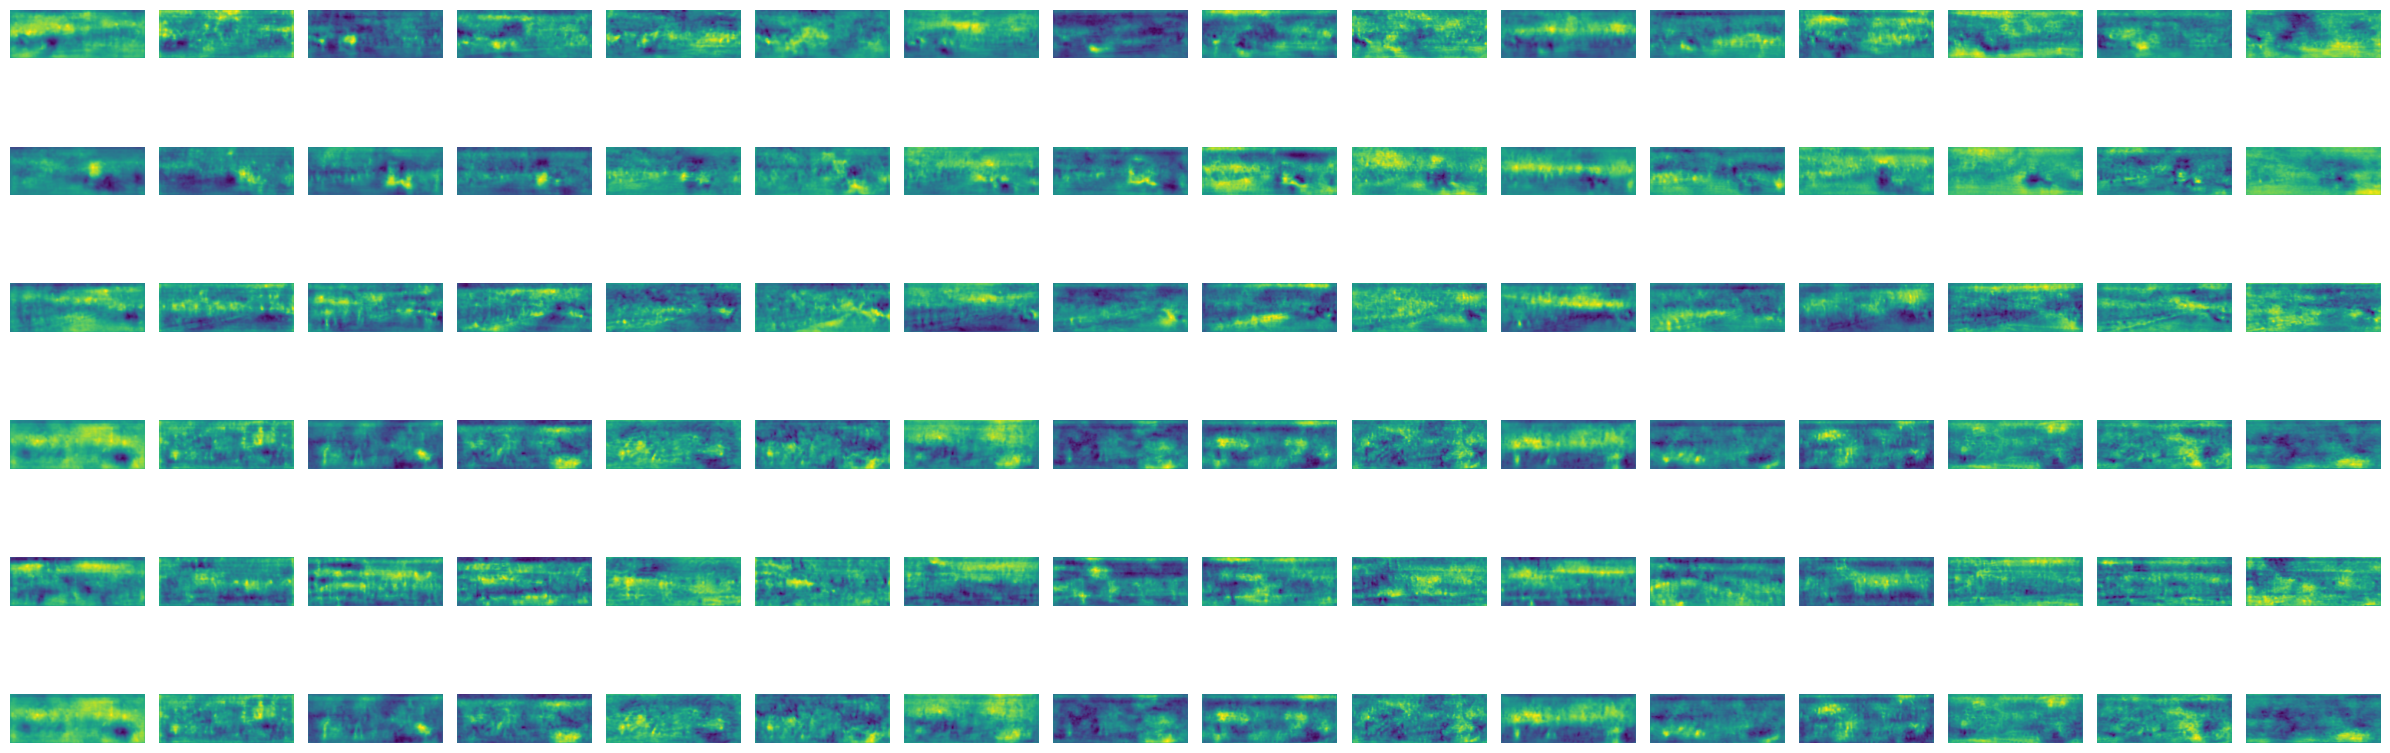

In [6]:
import matplotlib.pyplot as plt

model = torch.load(os.path.join(model_root_path, "fastbev_pre_trt.pth"), weights_only=False, map_location=DEVICE)
model.eval()
# 用包裝過的模型執行PTQ
#wrapper = WrapperModule(model)
#onnx_model = onnx.load(os.path.join(model_root_path, "fastbev_pre_trt.onnx"))
#model = convert(onnx_model).to(DEVICE)
model_int8 = model

num_samples = 50
sample_output_features = np.zeros((num_samples, batch_size, 64, 64, 176), dtype=np.float32)


output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
for imgid in range(num_samples):
    img_paths = next_image_paths(imgid+1)
    batch_images = preprocess_images(img_paths, input_size, mean, std)
    for i in range(batch_size):
        single_input_tensor = batch_images[i].unsqueeze(0)
        #print(i, single_input_tensor.shape)
        with torch.no_grad():
            backbone_output = model_int8(single_input_tensor)
            output_features[i] = backbone_output.cpu().numpy()    
    sample_output_features[imgid] = output_features     

num_images = output_features.shape[0]
num_channels = 16  # 只显示前 16 个通道

grid_rows = num_images
grid_cols = num_channels
for sample_idx in range(num_samples):
    plt.close()
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    output_features = sample_output_features[sample_idx]
    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            feature_map = output_features[img_idx, ch_idx, :, :]
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    print(f'Saving output_features_{sample_idx}.png')
    plt.savefig(f'data/features/output_features_{sample_idx}.png')

fastbev_pre_trt PTC training 

In [ ]:
import edgeai_torchmodelopt
from tqdm import tqdm
import os

model = torch.load(os.path.join(model_root_path, "fastbev_pre_trt.pth"), weights_only=False, map_location=DEVICE)
model.eval()
#onnx_model = onnx.load(os.path.join(model_root_path, "fastbev_pre_trt.onnx"))
#model = convert(onnx_model).to(DEVICE)
model.eval()


model_int8 = edgeai_torchmodelopt.xmodelopt.quantization.v2.PTCFxModule(model, backend='qnnpack', bias_calibration_factor=0.01, num_batch_norm_update_epochs=1, num_observer_update_epochs=2)

num_train_samples = 50
num_epochs = 3

for e in range(num_epochs):
    print(f"Epoch {e+1}/{num_epochs}")
    model_int8.train()
    for s in tqdm(range(num_train_samples)):    
        img_paths = next_image_paths(s+1)
        batch_images = preprocess_images(img_paths, input_size, mean, std)
        for i in range(batch_size):
            single_input_tensor = batch_images[i].unsqueeze(0).float()
            backbone_output = model_int8(single_input_tensor)


model_int8.export(batch_images[0].reshape(1,channels, height, width) ,os.path.join(model_root_path, "fastbev_pre_trt_int8.onnx"))

Verify the fastbev_pre_trt_int8

In [3]:
import onnxruntime as ort
import matplotlib.pyplot as plt
import numpy as np

# 假設 model_root_path, next_image_paths, preprocess_images, batch_size, channels, height, width, mean, std 都已定義
# original_model_path: 未量化的 ONNX 模型路徑
# quant_model_path: 量化後的 ONNX 模型路徑

#original_model_path = os.path.join(model_root_path, "fastbev_pre_trt.onnx")   # 未量化模型
quant_model_path = os.path.join(model_root_path, "fastbev_pre_trt_int8.onnx") # 量化後模型

# 建立ONNX推論session
#original_session = ort.InferenceSession(original_model_path, providers=['CPUExecutionProvider'])
quant_session = ort.InferenceSession(quant_model_path, providers=['CPUExecutionProvider'])

#original_output_name = original_session.get_outputs()[0].name
#original_input_name = original_session.get_inputs()[0].name

quant_output_name = quant_session.get_outputs()[0].name
quant_input_name = quant_session.get_inputs()[0].name

# 推論未量化模型
""" original_output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
for i in range(batch_size):
    start = time.time()
    out = original_session.run(
        [original_output_name],
        {original_input_name: batch_images[i].cpu().numpy().reshape(1, channels, height, width)}
    )[0]  # (1, 64, 64, 176)
    original_output_features[i] = out[0] """

# 推論量化後模型
num_samples = 50
sample_output_features = np.zeros((num_samples, batch_size, 64, 64, 176), dtype=np.float32)


quant_output_features = np.zeros((batch_size, 64, 64, 176), dtype=np.float32)
for imgid in range(num_samples):
    img_paths = next_image_paths(imgid+1)
    batch_images = preprocess_images(img_paths, input_size, mean, std)
    for i in range(batch_size):
        out = quant_session.run(
            [quant_output_name],
            {quant_input_name: batch_images[i].cpu().numpy().reshape(1, channels, height, width)}
        )[0]
        quant_output_features[i] = out[0]
        sample_output_features[imgid] = quant_output_features
# 設定要顯示的通道數
num_images = quant_output_features.shape[0]
num_channels = 16 # 顯示前16個通道

# 建立子圖: 
# 第一行: original model 特徵圖
# 第二行: quant model 特徵圖
# 第三行: 差異絕對值 (abs diff)
num_images = output_features.shape[0]
num_channels = 16  # 只显示前 16 个通道

grid_rows = num_images
grid_cols = num_channels
for sample_idx in range(num_samples):
    plt.close()
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    output_features = sample_output_features[sample_idx]
    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            feature_map = output_features[img_idx, ch_idx, :, :]
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    print(f"Saving output_features_{sample_idx}.png")
    plt.savefig(f'data/features/output_features_{sample_idx}.png')

KeyboardInterrupt: 

Proejct camera features to BEV

data/bev_features/bev_features_0.png
data/bev_features/bev_features_1.png
data/bev_features/bev_features_2.png
data/bev_features/bev_features_3.png
data/bev_features/bev_features_4.png
data/bev_features/bev_features_5.png
data/bev_features/bev_features_6.png
data/bev_features/bev_features_7.png
data/bev_features/bev_features_8.png
data/bev_features/bev_features_9.png
data/bev_features/bev_features_10.png
data/bev_features/bev_features_11.png
data/bev_features/bev_features_12.png
data/bev_features/bev_features_13.png
data/bev_features/bev_features_14.png
data/bev_features/bev_features_15.png
data/bev_features/bev_features_16.png
data/bev_features/bev_features_17.png
data/bev_features/bev_features_18.png
data/bev_features/bev_features_19.png
data/bev_features/bev_features_20.png
data/bev_features/bev_features_21.png
data/bev_features/bev_features_22.png
data/bev_features/bev_features_23.png
data/bev_features/bev_features_24.png
data/bev_features/bev_features_25.png
data/bev_features/bev_

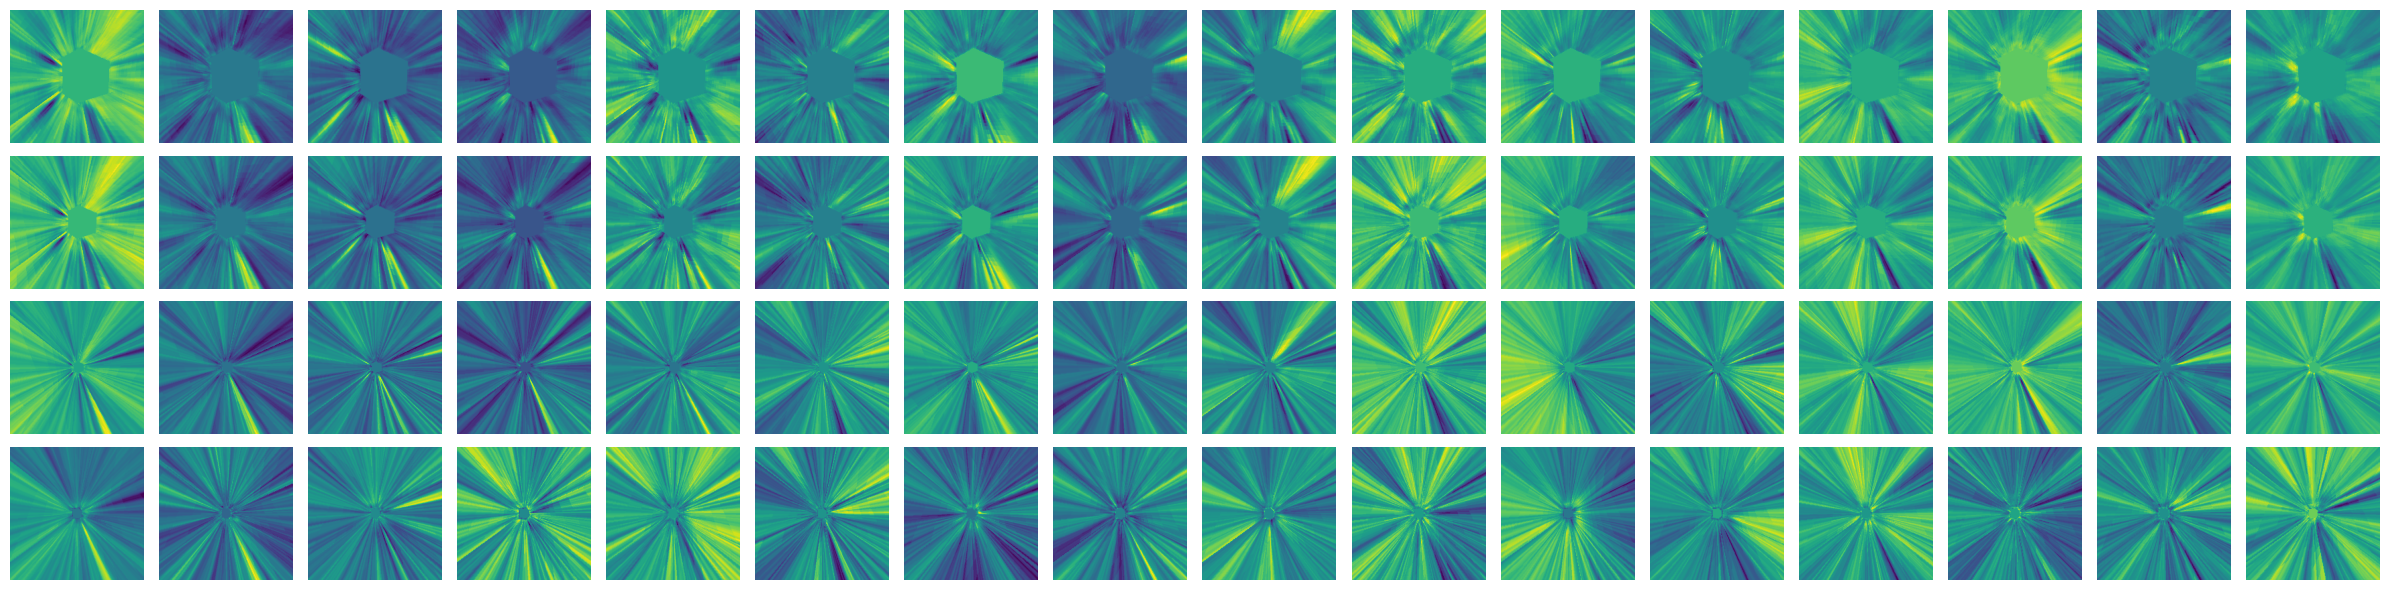

In [7]:
# SPDX-FileCopyrightText: Copyright (c) 2023 NVIDIA CORPORATION & AFFILIATES.
# SPDX-License-Identifier: MIT

import numpy as np
import struct
import os

class DataType:
    Float32 = 'Float32'
    Float16 = 'Float16'
    Int32 = 'Int32'
    Int64 = 'Int64'
    UInt64 = 'UInt64'
    UInt32 = 'UInt32'
    Int8 = 'Int8'
    UInt8 = 'UInt8'
    Int16 = 'Int16'
    UInt16 = 'UInt16'
    NoneType = 'None'

def dtype_string(dtype):
    return dtype

def dtype_bytes(dtype):
    dtype_map = {
        DataType.Float32: 4,
        DataType.Float16: 2,
        DataType.Int32: 4,
        DataType.Int64: 8,
        DataType.UInt64: 8,
        DataType.UInt32: 4,
        DataType.Int8: 1,
        DataType.UInt8: 1,
        DataType.Int16: 2,
        DataType.UInt16: 2,
    }
    return dtype_map.get(dtype, 0)

def format_shape(shape):
    return ' x '.join(map(str, shape))

class TensorData:
    def __init__(self, data=None, dtype=DataType.NoneType, device=False):
        self.data = data
        self.dtype = dtype
        self.device = device  # In this Python version, we will ignore device handling
        self.owner = True if data is not None else False

    @staticmethod
    def create(size, dtype):
        dtype_np = TensorData.dtype_to_numpy(dtype)
        data = np.zeros(size, dtype=dtype_np)
        return TensorData(data, dtype)

    @staticmethod
    def dtype_to_numpy(dtype):
        dtype_map = {
            DataType.Float32: np.float32,
            DataType.Float16: np.float16,
            DataType.Int32: np.int32,
            DataType.Int64: np.int64,
            DataType.UInt64: np.uint64,
            DataType.UInt32: np.uint32,
            DataType.Int8: np.int8,
            DataType.UInt8: np.uint8,
            DataType.Int16: np.int16,
            DataType.UInt16: np.uint16,
        }
        return dtype_map.get(dtype, np.float32)

class Tensor:
    def __init__(self, shape=None, dtype=DataType.Float32, device=False):
        self.shape = shape if shape is not None else []
        self.dtype = dtype
        self.device = device  # Device handling is omitted in this Python version
        self.data = None
        self.numel = np.prod(self.shape) if self.shape else 0
        self.ndim = len(self.shape)
        if self.numel > 0:
            self.data = TensorData.create(self.numel, self.dtype)

    @staticmethod
    def create(shape, dtype=DataType.Float32, device=False):
        return Tensor(shape, dtype, device)

    def empty(self):
        return self.data is None or self.numel == 0

    def ptr(self):
        return self.data.data if self.data else None

    def load(self, file_path):
        if not os.path.isfile(file_path):
            print(f"File {file_path} does not exist.")
            return None

        with open(file_path, 'rb') as f:
            head = f.read(12)
            if len(head) < 12:
                print(f"This is invalid tensor file {file_path}")
                return None

            magic_number, ndim, dtypei = struct.unpack('3i', head)
            if magic_number != 0x33FF1101:
                print(f"This is invalid tensor file {file_path}")
                return None

            dims = struct.unpack(f'{ndim}i', f.read(4 * ndim))
            shape = list(dims)
            volumn = np.prod(shape)
            dtype = self.int_to_dtype(dtypei)
            bytes_needed = volumn * dtype_bytes(dtype)

            data = f.read(bytes_needed)
            if len(data) < bytes_needed:
                print(f"This is invalid tensor file {file_path}")
                return None

            #dtype_np = np.dtype(TensorData.dtype_to_numpy(dtype))# 
            dtype_np = TensorData.dtype_to_numpy(dtype)# 
            #dtype_np = dtype_np.newbyteorder('>')
            tensor_data = np.frombuffer(data, dtype=dtype_np).reshape(shape)

            self.shape = shape
            self.dtype = dtype
            self.numel = volumn
            self.ndim = ndim
            self.data = TensorData(tensor_data, dtype)
            return self

    def save(self, file_path):
        if self.empty():
            print("Tensor is empty. Nothing to save.")
            return False

        with open(file_path, 'wb') as f:
            magic_number = 0x33FF1101
            ndim = self.ndim
            dtypei = self.dtype_to_int(self.dtype)
            head = struct.pack('3i', magic_number, ndim, dtypei)
            f.write(head)
            dims = struct.pack(f'{ndim}i', *self.shape)
            f.write(dims)
            f.write(self.data.data.tobytes())
        return True

    @staticmethod
    def dtype_to_int(dtype):
        dtype_map = {
            DataType.NoneType: 0,
            DataType.Int32: 1,
            DataType.Float16: 2,
            DataType.Float32: 3,
            DataType.Int64: 4,
            DataType.UInt64: 5,
            DataType.UInt32: 6,
            DataType.Int8: 7,
            DataType.UInt8: 8,
            DataType.UInt16: 9,
            DataType.Int16: 10,
        }
        return dtype_map.get(dtype, -1)

    @staticmethod
    def int_to_dtype(dtypei):
        dtype_map = {
            0: DataType.NoneType,
            1: DataType.Int32,
            2: DataType.Float16,
            3: DataType.Float32,
            4: DataType.Int64,
            5: DataType.UInt64,
            6: DataType.UInt32,
            7: DataType.Int8,
            8: DataType.UInt8,
            9: DataType.UInt16,
            10: DataType.Int16,
        }
        return dtype_map.get(dtypei, DataType.NoneType)

    def print(self, prefix='', offset=0, num_per_line=10, lines=1):
        print(f"{prefix}[{dtype_string(self.dtype)}] {format_shape(self.shape)}:", end='\n' if lines > 1 else ' ')
        if self.empty():
            print("empty.")
            return

        num_print = min(lines * num_per_line, self.numel)
        data_to_print = self.data.data.flatten()[offset:offset+num_print]
        for idx, value in enumerate(data_to_print):
            print(value, end=' ')
            if (idx + 1) % num_per_line == 0:
                print()
        if num_print % num_per_line != 0:
            print()

    def arange(self):
        if self.empty():
            return
        self.data.data = np.arange(self.numel, dtype=TensorData.dtype_to_numpy(self.dtype)).reshape(self.shape)

    def clone(self):
        if self.empty():
            return Tensor()
        cloned_tensor = Tensor(self.shape, self.dtype, self.device)
        cloned_tensor.data.data = np.copy(self.data.data)
        return cloned_tensor

    def to_float(self):
        if self.empty():
            return Tensor()
        if self.dtype == DataType.Float32:
            return self.clone()
        converted_tensor = Tensor(self.shape, DataType.Float32, self.device)
        converted_tensor.data.data = self.data.data.astype(np.float32)
        return converted_tensor

    def to_half(self):
        if self.empty():
            return Tensor()
        if self.dtype == DataType.Float16:
            return self.clone()
        converted_tensor = Tensor(self.shape, DataType.Float16, self.device)
        converted_tensor.data.data = self.data.data.astype(np.float16)
        return converted_tensor
    
    def np(self):
        if self.empty():
            return None
        return self.data.data

    def memset(self, value):
        if self.empty():
            return
        self.data.data.fill(value)

# 假设您已经将 valid_c_idx, x, y 数据保存为 .npy 文件
valid_c_idx = Tensor()
valid_c_idx = valid_c_idx.load(file_path='data/valid_c_idx.tensor')
valid_x = Tensor()
valid_x = valid_x.load(file_path='data/x.tensor')
valid_y = Tensor()
valid_y = valid_y.load(file_path='data/y.tensor')



def view_transform(camera_features, valid_c_idx, valid_x, valid_y):
    # camera_features: (num_cameras, channels, height, width)
    channels = camera_features.shape[1]
    volume_x = 200
    volume_y = 200
    volume_z = 4

    volume_shape = (channels, volume_x, volume_y, volume_z)
    num_cameras, channels, height, width = camera_features.shape
    num_valid = valid_c_idx.shape[1] 
    
    # 初始化输出 BEV 特征
    bev_features = np.zeros((channels*num_valid), dtype=np.float32)
    
    # 创建一个 mask，表示哪些点是有效的
    valid_mask = valid_c_idx == 1.0  # 形状为 (num_cameras, num_valid)
    
    for c in range(num_cameras):
        for i in range(num_valid):
            if valid_c_idx[c, i] == 0.0:
                continue
            x = valid_x[c, i]
            y = valid_y[c, i]
            """ for(int c=0; c< 64; c++){
                output_feature[c*num_valid+tid] = camera_feature[icamera*64*feat_height*feat_width+c*feat_height*feat_width +feat_width*y+x];
            } """
            for ch in range(channels):
                index = ch*num_valid+i
                i#f(index==0 or index==1000 or index==5000 or index==32758):
                    #print(x, y, c, camera_features[c, ch, y, x])
                bev_features[index] = camera_features[c, ch, y, x]
    #SLOG_INFO<<output_feature[0]<<", "<<output_feature[1000]<<", "<<output_feature[5000]<<", "<<output_feature[32758]<<std::endl;
    #print(bev_features[0], bev_features[1000], bev_features[5000], bev_features[32758])
    bev_features = bev_features.reshape(volume_shape)

    return bev_features

# 将 backbone_output 调整形状以匹配函数输入
# 假设 backbone_output 形状为 (1, num_cameras * channels, height, width)
num_cameras =  sample_output_features.shape[1]
channels =  sample_output_features.shape[2]
height =  sample_output_features.shape[3]
width =  sample_output_features.shape[4]

#print(valid_x.np().shape)
sample_bev_features = np.zeros((num_samples, 1, 64, 200, 200, 4), dtype=np.float32)
for sample_idx in range(num_samples):
    bev_features = view_transform(sample_output_features[sample_idx], valid_c_idx.np(), valid_x.np(), valid_y.np())
    bev_features = bev_features[np.newaxis, :, :]  # 形状为 (1, channels, volume_x, volume_y, volume_z)
    sample_bev_features[sample_idx] = bev_features
    # 显示 BEV 特征
    num_images = bev_features.shape[4]
    num_channels = 16  # 只显示前 16 个通道

    grid_rows = num_images
    grid_cols = num_channels

    plt.close()
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            feature_map = bev_features[0][ch_idx, :, :,img_idx]
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    print(f'data/bev_features/bev_features_{sample_idx}.png')
    plt.savefig(f'data/bev_features/bev_features_{sample_idx}.png')
    #plt.tight_layout()
    #plt.show()



Verify fastbev_post_trt.pth

In [8]:
import time

trtModel_post = torch.load(os.path.join(model_root_path, "fastbev_post_trt.pth"), weights_only=False, map_location=DEVICE)
trtModel_post.eval()

#model_int8 = edgeai_torchmodelopt.xmodelopt.quantization.v2.PTCFxModule(trtModel_post, backend='qnnpack', bias_calibration_factor=0.01, num_batch_norm_update_epochs=1, num_observer_update_epochs=2)


anchors = Tensor()
anchors = anchors.load(file_path="data/anchors.tensor")
anchors = torch.tensor(anchors.np(), dtype=torch.float32).to(DEVICE)

accu_time = 0
sample_results = []
for sample_idx in range(num_samples):
    time_start = time.time()
    tensor_input = torch.tensor(sample_bev_features[sample_idx], dtype=torch.float32).to(DEVICE)
    #print(tensor_input)
    with torch.no_grad():
        cls_scores,bbox_preds, dir_cls_scores = trtModel_post(tensor_input)
        dir_cls_pred = torch.max(dir_cls_scores, dim=-1)[1]
        """post_outputs = post_session.run(
            post_output_names,
            {post_input_name: sample_bev_features[sample_idx]}
        ) """
        accu_time += time.time() - time_start

        """cls_scores = post_outputs[0]
        bbox_preds = post_outputs[1]
        dir_cls_pred = post_outputs[2] """
        
        # 取每個樣本在所有類別的最大分數(沿 axis=1)
        max_scores, _= cls_scores.max(dim=1) #np.max(cls_scores, axis=1)  # shape (N,)

        # 取 top 1000 的索引值
        _, topk_inds =  max_scores.topk(1000)#np.argsort(-max_scores)[:1000]
        #print(topk_inds)

        # 根據 topk_inds 篩選 anchors、bbox_preds、cls_scores、dir_cls_pred
        anchorsTop = anchors[topk_inds, :]
        bbox_pred_ = bbox_preds[topk_inds, :]

        cls_scores = cls_scores[topk_inds, :]
        dir_cls_scores = dir_cls_pred[topk_inds]
        bbox_preds = decode(anchorsTop, bbox_pred_)

    #torch to numpy
    cls_scores = cls_scores.cpu().numpy()
    bbox_preds = bbox_preds.cpu().numpy()
    dir_cls_scores = dir_cls_scores.cpu().numpy()

    param = {
        'sorted_bboxes': True,
        'confidence_threshold': 0.0,
        'score_thr': 0.5,
        'max_num': 500,
        'dir_offset': 0.7854,  # 约等于 pi/4
        'dir_limit_offset': 0.0,
        'nms_radius_thr_list': [4.0, 12.0, 10.0, 10.0, 12.0, 0.85, 0.85, 0.175, 0.175, 1.0],
        'nms_thr_list': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.2],
        'nms_rescale_factor': [1.0, 0.7, 0.55, 0.4, 0.7, 1.0, 1.0, 4.5, 9.0, 1.0],
    }

    num_boxes = bbox_preds.shape[0]
    num_classes = cls_scores.shape[1]

    # 准备用于 NMS 的边界框
    mlvl_bboxes_for_nms = np.zeros((num_boxes, 5), dtype=np.float32)
    mlvl_bboxes_for_nms[:, 0] = bbox_preds[:, 0]# x_center
    mlvl_bboxes_for_nms[:, 1] = bbox_preds[:, 1]# y_center
    mlvl_bboxes_for_nms[:, 2] = bbox_preds[:, 3]  # width
    mlvl_bboxes_for_nms[:, 3] = bbox_preds[:, 4]  # length
    mlvl_bboxes_for_nms[:, 4] = bbox_preds[:, 6]  # rotation angle (in radians)

    results = []

    for i in range(num_classes):
        # 获取类别 i 的得分
        scores = cls_scores[:, i]
        mask = scores > param['score_thr']
        if np.sum(mask) == 0:
            continue  # 如果没有满足阈值的框，跳过

        # 提取当前类别的数据
        _scores_class = scores[mask]
        _bboxes_for_nms_class = mlvl_bboxes_for_nms[mask]
        _mlvl_bboxes_class = bbox_preds[mask]
        _mlvl_dir_scores_class = dir_cls_scores[mask]

        # 对边界框进行尺度调整
        nms_rescale = param['nms_rescale_factor'][i]
        _bboxes_for_nms_class = _bboxes_for_nms_class.copy()  # 避免修改原始数据
        _bboxes_for_nms_class[:, 2] *= nms_rescale  # width
        _bboxes_for_nms_class[:, 3] *= nms_rescale  # length

        # 执行 NMS
        if i == 9:
            # 对于类别索引为 9，使用圆形 NMS
            nms_thresh = param['nms_radius_thr_list'][i]
            selected = circle_nms_cpu(_bboxes_for_nms_class, _scores_class, nms_thresh)
        else:
            # 其他类别使用旋转 NMS
            nms_thresh = param['nms_thr_list'][i]
            # 准备 boxes for nms_rotated (x_center, y_center, width, height, angle_in_degrees)
            boxes_rotated = np.zeros((_bboxes_for_nms_class.shape[0], 5), dtype=np.float32)
            boxes_rotated[:, 0] = _bboxes_for_nms_class[:, 0]  # x_center
            boxes_rotated[:, 1] = _bboxes_for_nms_class[:, 1]  # y_center
            boxes_rotated[:, 2] = _bboxes_for_nms_class[:, 2]  # width
            boxes_rotated[:, 3] = _bboxes_for_nms_class[:, 3]  # length
            boxes_rotated[:, 4] = -_bboxes_for_nms_class[:, 4]  # angle (in radians)

            # 将数据转换为张量
        #boxes_tensor = torch.from_numpy(boxes_rotated).float()
            #scores_tensor = torch.from_numpy(_scores_class).float()

            # 执行旋转 NMS
            #from torchvision.ops import nms

            width = boxes_rotated[:, 2]
            height = boxes_rotated[:, 3]
            angle = boxes_rotated[:, 4]

            # Calculate the corners of the rotated boxes
            #cos_angle = np.cos(angle)
            #sin_angle = np.sin(angle)
            half_width = width * 0.5
            half_height = height * 0.5

            x_center = boxes_rotated[:, 0]
            y_center = boxes_rotated[:, 1]

            x1 = x_center-half_width
            y1 = y_center-half_height
            x2 = x_center + half_width
            y2 = y_center + half_height
                #print(cos_angle[0])
                #print(sin_angle[0])
            #x1r = (x1 - x_center) * cos_angle + (y1 - y_center) * (sin_angle) + x_center
            #y1r = -(x1 - x_center) * sin_angle + (y1 - y_center) * (cos_angle) + y_center
            #x2r = (x2 - x_center) * cos_angle + (y2 - y_center) * (sin_angle) + x_center
            #y2r = -(x2 - x_center) * sin_angle + (y2 - y_center) * (cos_angle) + y_center

                
            # Create axis-aligned boxes
            xyxy =  np.stack([x1, y1, x2, y2, angle], axis=1)

            selected = nms_cpu(xyxy, _scores_class, nms_thresh)

        # 构建最终的检测结果
        for idx in selected:
            bbox = {}
            # 位置
            bbox['position'] = {
                'x': _mlvl_bboxes_class[idx][0],
                'y': _mlvl_bboxes_class[idx][1],
                'z': _mlvl_bboxes_class[idx][2],
            }
            # 尺寸
            bbox['size'] = {
                'w': _mlvl_bboxes_class[idx][3],
                'l': _mlvl_bboxes_class[idx][4],
                'h': _mlvl_bboxes_class[idx][5],
            }
            # 计算旋转角度
            dir_rot = limit_period(_mlvl_bboxes_class[idx][6] - param['dir_offset'],
                                np.pi)
            bbox['z_rotation'] = dir_rot + param['dir_offset'] + np.pi * _mlvl_dir_scores_class[idx]
            # 速度
            bbox['velocity'] = {
                'vx': _mlvl_bboxes_class[idx][7],
                'vy': _mlvl_bboxes_class[idx][8],
            }
            bbox['score'] = _scores_class[idx]
            bbox['id'] = i  # 类别 ID
            results.append(bbox)

    # 根据需要排序并限制结果数量
    if param['sorted_bboxes']:
        # 根据得分从高到低排序
        results = sorted(results, key=lambda x: x['score'], reverse=True)

    # 限制返回的边界框数量
    if len(results) > param['max_num']:
        results = results[:param['max_num']]

    #from pprint import pprint

    print("Number of detected objects:", len(results))
    #pprint(results)
    save_box_pred_csv(results, 'data/results/result_{:1d}.csv'.format(sample_idx))
    sample_results.append(results)

print("Inference time:", accu_time/num_samples)



Number of detected objects: 57
Saved prediction in: data/results/result_0.csv
Number of detected objects: 91
Saved prediction in: data/results/result_1.csv
Number of detected objects: 49
Saved prediction in: data/results/result_2.csv
Number of detected objects: 53
Saved prediction in: data/results/result_3.csv
Number of detected objects: 27
Saved prediction in: data/results/result_4.csv
Number of detected objects: 71
Saved prediction in: data/results/result_5.csv
Number of detected objects: 49
Saved prediction in: data/results/result_6.csv
Number of detected objects: 32
Saved prediction in: data/results/result_7.csv
Number of detected objects: 33
Saved prediction in: data/results/result_8.csv
Number of detected objects: 38
Saved prediction in: data/results/result_9.csv
Number of detected objects: 36
Saved prediction in: data/results/result_10.csv
Number of detected objects: 45
Saved prediction in: data/results/result_11.csv
Number of detected objects: 26
Saved prediction in: data/resul

PTQ: fastbev_post_trt 

In [12]:
import edgeai_torchmodelopt
from tqdm import tqdm
import os

trtModel_post = torch.load(os.path.join(model_root_path, "fastbev_post_trt.pth"), weights_only=False, map_location=DEVICE)
trtModel_post.eval()

model_int8 = edgeai_torchmodelopt.xmodelopt.quantization.v2.PTCFxModule(trtModel_post, backend='qnnpack', bias_calibration_factor=0.01, num_batch_norm_update_epochs=1, num_observer_update_epochs=2)

print("Number of samples: ", num_samples)    
num_epochs = 3

for e in range(num_epochs):
    print(f"Epoch {e+1}/{num_epochs}")
    model_int8.train()
    for sample_idx in tqdm(range(num_samples)):  
        tensor_input = torch.tensor(sample_bev_features[sample_idx], dtype=torch.float32).to(DEVICE)
        cls_scores,bbox_preds, dir_cls_scores = model_int8(tensor_input)

tensor_input = torch.tensor(sample_bev_features[0], dtype=torch.float32).to(DEVICE)
model_int8.export(tensor_input ,os.path.join(model_root_path, "fastbev_post_trt_int8.onnx"))

Model Preparation is now complete! 
Number of samples:  50
Epoch 1/3


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 2/3
Freezing BN for subsequent epochs


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Epoch 3/3
Freezing ranges for subsequent epochs


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Verify fastbev_post_trt_int8

In [13]:
post_model_path = os.path.join(model_root_path, 'fastbev_post_trt_int8.onnx')
post_session = ort.InferenceSession(post_model_path)

post_input_name = post_session.get_inputs()[0].name
post_output_names = [output.name for output in post_session.get_outputs()]

#model_int8 = edgeai_torchmodelopt.xmodelopt.quantization.v2.PTCFxModule(trtModel_post, backend='qnnpack', bias_calibration_factor=0.01, num_batch_norm_update_epochs=1, num_observer_update_epochs=2)


anchors = Tensor()
anchors = anchors.load(file_path="data/anchors.tensor")
anchors = torch.tensor(anchors.np(), dtype=torch.float32).to(DEVICE)

accu_time = 0
sample_results = []
for sample_idx in range(num_samples):
    time_start = time.time()
    tensor_input = torch.tensor(sample_bev_features[sample_idx], dtype=torch.float32).to(DEVICE)
    #print(tensor_input)
    with torch.no_grad():
        post_outputs = post_session.run(
            post_output_names,
            {post_input_name: sample_bev_features[sample_idx]}
        )
        accu_time += time.time() - time_start

        cls_scores = post_outputs[0]
        bbox_preds = post_outputs[1]
        dir_cls_scores = torch.tensor(post_outputs[2], dtype=torch.float32).to(DEVICE)
        dir_cls_pred = torch.max(dir_cls_scores, dim=-1)[1]
        
        cls_scores = torch.tensor(cls_scores, dtype=torch.float32).to(DEVICE)
        bbox_preds = torch.tensor(bbox_preds, dtype=torch.float32).to(DEVICE)
        dir_cls_pred = torch.tensor(dir_cls_pred, dtype=torch.float32).to(DEVICE)
        # 取每個樣本在所有類別的最大分數(沿 axis=1)
        max_scores, _= cls_scores.max(dim=1) #np.max(cls_scores, axis=1)  # shape (N,)

        # 取 top 1000 的索引值
        _, topk_inds =  max_scores.topk(1000)#np.argsort(-max_scores)[:1000]
        #print(topk_inds)

        # 根據 topk_inds 篩選 anchors、bbox_preds、cls_scores、dir_cls_pred
        anchorsTop = anchors[topk_inds, :]
        bbox_pred_ = bbox_preds[topk_inds, :]

        cls_scores = cls_scores[topk_inds, :]
        dir_cls_scores = dir_cls_pred[topk_inds]
        bbox_preds = decode(anchorsTop, bbox_pred_)

    #torch to numpy
    cls_scores = cls_scores.cpu().numpy()
    bbox_preds = bbox_preds.cpu().numpy()
    dir_cls_scores = dir_cls_scores.cpu().numpy()

    param = {
        'sorted_bboxes': True,
        'confidence_threshold': 0.0,
        'score_thr': 0.5,
        'max_num': 500,
        'dir_offset': 0.7854,  # 约等于 pi/4
        'dir_limit_offset': 0.0,
        'nms_radius_thr_list': [4.0, 12.0, 10.0, 10.0, 12.0, 0.85, 0.85, 0.175, 0.175, 1.0],
        'nms_thr_list': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.2],
        'nms_rescale_factor': [1.0, 0.7, 0.55, 0.4, 0.7, 1.0, 1.0, 4.5, 9.0, 1.0],
    }

    num_boxes = bbox_preds.shape[0]
    num_classes = cls_scores.shape[1]

    # 准备用于 NMS 的边界框
    mlvl_bboxes_for_nms = np.zeros((num_boxes, 5), dtype=np.float32)
    mlvl_bboxes_for_nms[:, 0] = bbox_preds[:, 0]# x_center
    mlvl_bboxes_for_nms[:, 1] = bbox_preds[:, 1]# y_center
    mlvl_bboxes_for_nms[:, 2] = bbox_preds[:, 3]  # width
    mlvl_bboxes_for_nms[:, 3] = bbox_preds[:, 4]  # length
    mlvl_bboxes_for_nms[:, 4] = bbox_preds[:, 6]  # rotation angle (in radians)

    results = []

    for i in range(num_classes):
        # 获取类别 i 的得分
        scores = cls_scores[:, i]
        mask = scores > param['score_thr']
        if np.sum(mask) == 0:
            continue  # 如果没有满足阈值的框，跳过

        # 提取当前类别的数据
        _scores_class = scores[mask]
        _bboxes_for_nms_class = mlvl_bboxes_for_nms[mask]
        _mlvl_bboxes_class = bbox_preds[mask]
        _mlvl_dir_scores_class = dir_cls_scores[mask]

        # 对边界框进行尺度调整
        nms_rescale = param['nms_rescale_factor'][i]
        _bboxes_for_nms_class = _bboxes_for_nms_class.copy()  # 避免修改原始数据
        _bboxes_for_nms_class[:, 2] *= nms_rescale  # width
        _bboxes_for_nms_class[:, 3] *= nms_rescale  # length

        # 执行 NMS
        if i == 9:
            # 对于类别索引为 9，使用圆形 NMS
            nms_thresh = param['nms_radius_thr_list'][i]
            selected = circle_nms_cpu(_bboxes_for_nms_class, _scores_class, nms_thresh)
        else:
            # 其他类别使用旋转 NMS
            nms_thresh = param['nms_thr_list'][i]
            # 准备 boxes for nms_rotated (x_center, y_center, width, height, angle_in_degrees)
            boxes_rotated = np.zeros((_bboxes_for_nms_class.shape[0], 5), dtype=np.float32)
            boxes_rotated[:, 0] = _bboxes_for_nms_class[:, 0]  # x_center
            boxes_rotated[:, 1] = _bboxes_for_nms_class[:, 1]  # y_center
            boxes_rotated[:, 2] = _bboxes_for_nms_class[:, 2]  # width
            boxes_rotated[:, 3] = _bboxes_for_nms_class[:, 3]  # length
            boxes_rotated[:, 4] = -_bboxes_for_nms_class[:, 4]  # angle (in radians)

            # 将数据转换为张量
        #boxes_tensor = torch.from_numpy(boxes_rotated).float()
            #scores_tensor = torch.from_numpy(_scores_class).float()

            # 执行旋转 NMS
            #from torchvision.ops import nms

            width = boxes_rotated[:, 2]
            height = boxes_rotated[:, 3]
            angle = boxes_rotated[:, 4]

            # Calculate the corners of the rotated boxes
            #cos_angle = np.cos(angle)
            #sin_angle = np.sin(angle)
            half_width = width * 0.5
            half_height = height * 0.5

            x_center = boxes_rotated[:, 0]
            y_center = boxes_rotated[:, 1]

            x1 = x_center-half_width
            y1 = y_center-half_height
            x2 = x_center + half_width
            y2 = y_center + half_height
                #print(cos_angle[0])
                #print(sin_angle[0])
            #x1r = (x1 - x_center) * cos_angle + (y1 - y_center) * (sin_angle) + x_center
            #y1r = -(x1 - x_center) * sin_angle + (y1 - y_center) * (cos_angle) + y_center
            #x2r = (x2 - x_center) * cos_angle + (y2 - y_center) * (sin_angle) + x_center
            #y2r = -(x2 - x_center) * sin_angle + (y2 - y_center) * (cos_angle) + y_center

                
            # Create axis-aligned boxes
            xyxy =  np.stack([x1, y1, x2, y2, angle], axis=1)

            selected = nms_cpu(xyxy, _scores_class, nms_thresh)

        # 构建最终的检测结果
        for idx in selected:
            bbox = {}
            # 位置
            bbox['position'] = {
                'x': _mlvl_bboxes_class[idx][0],
                'y': _mlvl_bboxes_class[idx][1],
                'z': _mlvl_bboxes_class[idx][2],
            }
            # 尺寸
            bbox['size'] = {
                'w': _mlvl_bboxes_class[idx][3],
                'l': _mlvl_bboxes_class[idx][4],
                'h': _mlvl_bboxes_class[idx][5],
            }
            # 计算旋转角度
            dir_rot = limit_period(_mlvl_bboxes_class[idx][6] - param['dir_offset'],
                                np.pi)
            bbox['z_rotation'] = dir_rot + param['dir_offset'] + np.pi * _mlvl_dir_scores_class[idx]
            # 速度
            bbox['velocity'] = {
                'vx': _mlvl_bboxes_class[idx][7],
                'vy': _mlvl_bboxes_class[idx][8],
            }
            bbox['score'] = _scores_class[idx]
            bbox['id'] = i  # 类别 ID
            results.append(bbox)

    # 根据需要排序并限制结果数量
    if param['sorted_bboxes']:
        # 根据得分从高到低排序
        results = sorted(results, key=lambda x: x['score'], reverse=True)

    # 限制返回的边界框数量
    if len(results) > param['max_num']:
        results = results[:param['max_num']]

    #from pprint import pprint

    print("Number of detected objects:", len(results))
    #pprint(results)
    save_box_pred_csv(results, 'data/results/result_{:1d}.csv'.format(sample_idx))
    sample_results.append(results)

print("Inference time:", accu_time/num_samples)

Number of detected objects: 51
Saved prediction in: data/results/result_0.csv
Number of detected objects: 77
Saved prediction in: data/results/result_1.csv
Number of detected objects: 46
Saved prediction in: data/results/result_2.csv
Number of detected objects: 43
Saved prediction in: data/results/result_3.csv
Number of detected objects: 28
Saved prediction in: data/results/result_4.csv
Number of detected objects: 66
Saved prediction in: data/results/result_5.csv
Number of detected objects: 44
Saved prediction in: data/results/result_6.csv
Number of detected objects: 30
Saved prediction in: data/results/result_7.csv
Number of detected objects: 33
Saved prediction in: data/results/result_8.csv
Number of detected objects: 36
Saved prediction in: data/results/result_9.csv
Number of detected objects: 32
Saved prediction in: data/results/result_10.csv
Number of detected objects: 40
Saved prediction in: data/results/result_11.csv
Number of detected objects: 28
Saved prediction in: data/resul

Visualization of the post process....

In [14]:
import json
import os
import cv2
import numpy as np
import torch
from pyquaternion.quaternion import Quaternion


def check_point_in_img(points, height, width):
    valid = np.logical_and(points[:, 0] >= 0, points[:, 1] >= 0)
    valid = np.logical_and(valid, np.logical_and(points[:, 0] < width, points[:, 1] < height))
    return valid


def depth2color(depth):
    gray = max(0, min((depth + 2.5) / 3.0, 1.0))
    max_lumi = 200
    colors = np.array([[max_lumi, 0, max_lumi], 
                       [max_lumi, 0, 0],
                       [max_lumi, max_lumi, 0],
                       [0, max_lumi, 0], 
                       [0, max_lumi, max_lumi], 
                       [0, 0, max_lumi]],
        dtype=np.float32)
    if gray == 1:
        return tuple(colors[-1].tolist())
    num_rank = len(colors) - 1
    rank     = np.floor(gray * num_rank).astype(np.int32)
    diff     = (gray - rank / num_rank) * num_rank
    return tuple((colors[rank] + (colors[rank + 1] - colors[rank]) * diff).tolist())


def lidar2img(points_lidar, camrera_info):
    points_lidar_homogeneous  = np.concatenate([points_lidar, np.ones((points_lidar.shape[0], 1), dtype=points_lidar.dtype)], axis=1)
    
    lidar2camera              = camrera_info['lidar2img']['extrinsic']
    lidar2camera              = np.array(lidar2camera, dtype=np.float32)
    points_camera_homogeneous = points_lidar_homogeneous @ lidar2camera.T
    points_camera             = points_camera_homogeneous[:, :3]
    valid                     = np.ones((points_camera.shape[0]), dtype=bool)
    valid                     = np.logical_and(points_camera[:, -1] > 0.5, valid)
    points_camera             = points_camera / points_camera[:, 2:3]
    camera2img                = np.array(camrera_info['lidar2img']['intrinsic'])
    points_img                = points_camera @ camera2img.T
    post_aug                  = np.eye(3, dtype=np.float32)
    post_aug[:2, :2]          = np.array(camrera_info['post_rot'])[:2,:2]
    post_aug[:2, 2]           = np.array(camrera_info['post_tran'])[:2]
    points_img                = np.linalg.inv(post_aug) @ points_img.transpose(1,0)
    points_img                = points_img.transpose(1,0)[:, :2]
    return points_img, valid


def get_lidar2global(lidar2ego_rotation, lidar2ego_translation, ego2global_rotation, ego2global_translation):
    lidar2ego          = np.eye(4, dtype=np.float32)
    lidar2ego[:3, :3]  = Quaternion(lidar2ego_rotation).rotation_matrix
    lidar2ego[:3, 3]   = lidar2ego_translation
    ego2global         = np.eye(4, dtype=np.float32)
    ego2global[:3, :3] = Quaternion(ego2global_rotation).rotation_matrix
    ego2global[:3, 3]  = ego2global_translation
    return ego2global @ lidar2ego

def create_lidar_box3d(tensor, box_dim=7, with_yaw=True, origin=(0.5, 0.5, 0)):
    if isinstance(tensor, torch.Tensor):
        device = tensor.device
    else:
        device = torch.device('cpu')
    tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
    if tensor.numel() == 0:
        # Use reshape, so we don't end up creating a new tensor that
        # does not depend on the inputs (and consequently confuses jit)
        tensor = tensor.reshape((0, box_dim)).to(
            dtype=torch.float32, device=device)
    assert tensor.dim() == 2 and tensor.size(-1) == box_dim, tensor.size()

    if tensor.shape[-1] == 6:
        # If the dimension of boxes is 6, we expand box_dim by padding
        # 0 as a fake yaw and set with_yaw to False.
        assert box_dim == 6
        fake_rot = tensor.new_zeros(tensor.shape[0], 1)
        tensor = torch.cat((tensor, fake_rot), dim=-1)
        box_dim = box_dim + 1
        with_yaw = False
    else:
        box_dim = box_dim
        with_yaw = with_yaw
    #tensor = tensor.clone()

    if origin != (0.5, 0.5, 0):
        dst = tensor.new_tensor((0.5, 0.5, 0))
        src = tensor.new_tensor(origin)
        tensor[:, :3] += tensor[:, 3:6] * (dst - src)
    return tensor

def rotation_3d_in_axis(points, angles, axis=0):
    """Rotate points by angles according to axis.

    Args:
        points (torch.Tensor): Points of shape (N, M, 3).
        angles (torch.Tensor): Vector of angles in shape (N,)
        axis (int, optional): The axis to be rotated. Defaults to 0.

    Raises:
        ValueError: when the axis is not in range [0, 1, 2], it will \
            raise value error.

    Returns:
        torch.Tensor: Rotated points in shape (N, M, 3)
    """
    rot_sin = torch.sin(angles)
    rot_cos = torch.cos(angles)
    ones = torch.ones_like(rot_cos)
    zeros = torch.zeros_like(rot_cos)
    if axis == 1:
        rot_mat_T = torch.stack([
            torch.stack([rot_cos, zeros, -rot_sin]),
            torch.stack([zeros, ones, zeros]),
            torch.stack([rot_sin, zeros, rot_cos])
        ])
    elif axis == 2 or axis == -1:
        rot_mat_T = torch.stack([
            torch.stack([rot_cos, -rot_sin, zeros]),
            torch.stack([rot_sin, rot_cos, zeros]),
            torch.stack([zeros, zeros, ones])
        ])
    elif axis == 0:
        rot_mat_T = torch.stack([
            torch.stack([zeros, rot_cos, -rot_sin]),
            torch.stack([zeros, rot_sin, rot_cos]),
            torch.stack([ones, zeros, zeros])
        ])
    else:
        raise ValueError(f'axis should in range [0, 1, 2], got {axis}')

    return torch.einsum('aij,jka->aik', (points, rot_mat_T))

def corners(dims, tensor):
    """torch.Tensor: Coordinates of corners of all the boxes
    in shape (N, 8, 3).

    Convert the boxes to corners in clockwise order, in form of
    ``(x0y0z0, x0y0z1, x0y1z1, x0y1z0, x1y0z0, x1y0z1, x1y1z1, x1y1z0)``

    .. code-block:: none

                                           up z
                            front x           ^
                                 /            |
                                /             |
                  (x1, y0, z1) + -----------  + (x1, y1, z1)
                              /|            / |
                             / |           /  |
               (x0, y0, z1) + ----------- +   + (x1, y1, z0)
                            |  /      .   |  /
                            | / oriign    | /
            left y<-------- + ----------- + (x0, y1, z0)
                (x0, y0, z0)
    """
    # TODO: rotation_3d_in_axis function do not support
    #  empty tensor currently.
    corners_norm = torch.from_numpy(
        np.stack(np.unravel_index(np.arange(8), [2] * 3), axis=1)).to(
            device=dims.device, dtype=dims.dtype)

    corners_norm = corners_norm[[0, 1, 3, 2, 4, 5, 7, 6]]
    # use relative origin [0.5, 0.5, 0]
    corners_norm = corners_norm - dims.new_tensor([0.5, 0.5, 0])
    corners = dims.view([-1, 1, 3]) * corners_norm.reshape([1, 8, 3])

    # rotate around z axis
    corners = rotation_3d_in_axis(corners, tensor[:, 6], axis=2)
    corners += tensor[:, :3].view(-1, 1, 3)
    return corners

def convert_predictions_to_arrays(results):
    import numpy as np

    bboxes = []
    scores = []
    cls_arr = []

    for bbox in results:
        # 提取位置和尺寸信息
        x = bbox['position']['x']
        y = bbox['position']['y']
        z = bbox['position']['z']
        w = bbox['size']['w']
        l = bbox['size']['l']
        h = bbox['size']['h']
        # 提取旋转角度
        yaw = bbox['z_rotation']
        # 构建边界框数组，格式为 [x, y, z, w, l, h, yaw]
        bboxes.append([x, y, z, w, l, h, yaw])
        # 提取得分
        scores.append(bbox['score'])
        # 提取类别 ID
        cls_arr.append(bbox['id'])

    # 将列表转换为 NumPy 数组
    bboxes = np.array(bboxes, dtype=np.float32)
    scores = np.array(scores, dtype=np.float32)
    cls_arr = np.array(cls_arr, dtype=np.int32)

    return bboxes, scores, cls_arr

def visualize(data_root, predictions,vis_path, sample_idx):
    info_dict = None
    with open(os.path.join(data_root, "sensor.json"), 'r') as f:
        info_dict = json.load(f)
    cam_info_dict = info_dict['cams']

    #bboxes, scores, cls_arr = read_txt_to_array(pred_path)
    bboxes, scores, cls_arr = convert_predictions_to_arrays(predictions)

    # 定义绘制BEV视角下框的索引
    draw_boxes_indexes_bev      = [(0, 1), (1, 2), (2, 3), (3, 0)]
    draw_boxes_indexes_img_view = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), 
                                   (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]
    canva_size   = 1000
    show_range   = 50
    scale_factor = 4
    color_map    = {0: (255, 255, 0), 1: (0, 255, 255)}

    # 定义相机视角列表
    print('start visualizing results')
    pred_boxes        = np.array(bboxes, dtype=np.float32)
    #corners_lidar     = LB(pred_boxes, origin=(0.5, 0.5, 0)).corners.numpy().reshape(-1, 3)
    box3d = create_lidar_box3d(pred_boxes, origin=(0.5, 0.5, 0))
    box3d_dims = box3d[:, 3:6]
    corners_lidar = corners(box3d_dims, box3d).numpy().reshape(-1, 3)

    #print(corners_lidar)
    #dd = LB(pred_boxes, origin=(0.5, 0.5, 0)).corners.numpy().reshape(-1, 3)
    #print(dd)

    pred_flag = np.ones((corners_lidar.shape[0] // 8, ), dtype=np.bool)
    scores    = np.array(scores, dtype=np.float32)

    # 构建预测框的标志数组
    sort_ids  = np.argsort(scores)

    # 对相机视角进行可视化
    imgs = []
    views = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
    img_paths = []
    img_paths.append(f'data/samples/front_left/front_left_{sample_idx+1}.jpg')
    img_paths.append(f'data/samples/front/front_{sample_idx+1}.jpg')
    img_paths.append(f'data/samples/front_right/front_right_{sample_idx+1}.jpg')
    img_paths.append(f'data/samples/back_left/back_left_{sample_idx+1}.jpg')
    img_paths.append(f'data/samples/back/back_{sample_idx+1}.jpg')
    img_paths.append(f'data/samples/back_right/back_right_{sample_idx+1}.jpg')
    idx = 0
    for view in views:
        img = cv2.imread(img_paths[idx])
        idx += 1
        # 将雷达坐标转换为图像坐标并绘制目标框
        corners_img, valid = lidar2img(corners_lidar, cam_info_dict[view])
        valid = valid.reshape(-1, 8)
        corners_img = corners_img.reshape(-1, 8, 2).astype(np.int32)
        for aid in range(valid.shape[0]):
            for index in draw_boxes_indexes_img_view:
                if valid[aid, index[0]] and valid[aid, index[1]]:
                    cv2.line(img, corners_img[aid, index[0]], corners_img[aid, index[1]],
                            color=color_map[int(pred_flag[aid])], thickness=scale_factor)
        imgs.append(img)

    # 构建BEV视图的画布
    canvas = np.zeros((int(canva_size), int(canva_size), 3), dtype=np.uint8)


    ## 绘制中心点和距离
    center_ego = (0, 0)
    center_canvas = int((center_ego[0] + show_range) / show_range / 2.0 * canva_size)
    cv2.circle(canvas, center=(center_canvas, center_canvas), radius=1, color=(255, 255, 255), thickness=0)
    dis = 10
    for r in range(dis, 100, dis):
        r_canvas = int(r / show_range / 2.0 * canva_size)
        cv2.circle(canvas, center=(center_canvas, center_canvas), radius=r_canvas, color=depth2color(r), thickness=0)
        
    
    # 绘制BEV视角下的预测框
    corners_lidar          = corners_lidar.reshape(-1, 8, 3)
    corners_lidar[:, :, 1] = -corners_lidar[:, :, 1]
    bottom_corners_bev     = corners_lidar[:, [0, 3, 7, 4], :2]
    bottom_corners_bev     = (bottom_corners_bev + show_range) / show_range / 2.0 * canva_size
    bottom_corners_bev     = np.round(bottom_corners_bev).astype(np.int32)
    center_bev             = corners_lidar[:, [0, 3, 7, 4], :2].mean(axis=1)
    head_bev               = corners_lidar[:, [0, 4], :2].mean(axis=1)
    canter_canvas          = (center_bev + show_range) / show_range / 2.0 * canva_size
    center_canvas          = canter_canvas.astype(np.int32)
    head_canvas            = (head_bev + show_range) / show_range / 2.0 * canva_size
    head_canvas            = head_canvas.astype(np.int32)

    # 在BEV视角下绘制预测框
    for rid in sort_ids:
        score = scores[rid]
        if score < 0.2 and pred_flag[rid]:
            continue
        score = min(score * 2.0, 1.0) if pred_flag[rid] else 1.0
        color = color_map[int(pred_flag[rid])]
        for index in draw_boxes_indexes_bev:
            cv2.line(canvas, bottom_corners_bev[rid, index[0]], bottom_corners_bev[rid, index[1]],
                    [color[0] * score, color[1] * score, color[2] * score], thickness=1)
        cv2.line(canvas, center_canvas[rid], head_canvas[rid], [color[0] * score, color[1] * score, color[2] * score], 1, lineType=8)

    # 融合图像视角和BEV视角的结果
    img = np.zeros((900 * 2 + canva_size * scale_factor, 1600 * 3, 3), dtype=np.uint8)
    img[:900, :, :] = np.concatenate(imgs[:3], axis=1)
    img_back = np.concatenate([imgs[3][:, ::-1, :], imgs[4][:, ::-1, :], imgs[5][:, ::-1, :]], axis=1)
    img[900 + canva_size * scale_factor:, :, :] = img_back
    img = cv2.resize(img, (int(1600 / scale_factor * 3), int(900 / scale_factor * 2 + canva_size)))
    w_begin = int((1600 * 3 / scale_factor - canva_size) // 2)
    img[int(900 / scale_factor):int(900 / scale_factor) + canva_size, w_begin:w_begin + canva_size, :] = canvas

    # 保存可视化结果
    
    #cv2.imwrite(vis_path, img)
    plt.close()
    plt.figure(figsize=(25, 12))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis ticks and labels
    #plt.show()
    plt.savefig(vis_path)  
    print(f'Saved visual result to {vis_path}')


""" def convert_tensors_to_lists(data):
    if isinstance(data, dict):
        return {key: convert_tensors_to_lists(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_tensors_to_lists(element) for element in data]
    elif isinstance(data, torch.Tensor):
        return data.tolist()
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

def save_info_dict_to_json(info_dict, output_file):
    # 首先将不可序列化的数据类型转换为可序列化的类型
    serializable_info_dict = convert_tensors_to_lists(info_dict)

    # 保存为 JSON 文件
    with open(output_file, 'w') as f:
        json.dump(serializable_info_dict, f, indent=4)

    print(f"Saved info_dict to {output_file}") """

if __name__ == '__main__':

    data_root  = 'data'
    pred_path  = 'result.txt'
    vis_path   = os.path.join(data_root, "sample0_vis.png")

    for sample_idx in range(num_samples):
        visualize(data_root, sample_results[sample_idx], f'data/results/result_{sample_idx}.png', sample_idx)
    #save_info_dict_to_json(read_data_file('example-data'), 'example-data.json')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (51, 7) + inhomogeneous part.